In [44]:
!pip install tensorflow-gpu==1.13.1

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==1.13.1 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==1.13.1


In [45]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:150% !important; }</style>"))

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

import os, warnings
warnings.filterwarnings('ignore')

In [47]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_CHANNELS = 1
CONDITIONAL_IMAGE_CHANNELS = 10
BATCH_SIZE = 64
LATENT_DIMENSION = 100
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
CONDITIONAL_IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, CONDITIONAL_IMAGE_CHANNELS)
EPOCHS = 100

In [48]:
INPUT_FEATURES = ['elevation', 'wind_speed', 'wind_dir', 'tmin', 'tmax',
                  'landcover', 'precip', 'pdsi','solar', 'PrevFireMask']

In [49]:
man_length = 21550

MinMax = {'landcover':(10.0, 100.0),
              'tmax': (-41.95404185202824, 35.28747487720835),
              'tmin': (-42.4077221254351, 34.710974191122716),
              'wind_speed': (0.0002993076576944125, 14.27423496286687),
              'elevation': (-77.85292, 4379.4683),
              'wind_direction': (-179.99999083334689, 179.99999810000588),
              'solar_radiation': (-24.598765964771623, 964662.1183104622),
              'air_pressure': (99064.73425290409, 105551.80433948596),
              'precipitation': (-9.494998975299606e-05, 0.012117456275976952)}

In [50]:
def _parse_function(proto):

    keys_to_features = {
        'feature1': tf.io.VarLenFeature(tf.float32),
        'feature2': tf.io.VarLenFeature(tf.float32),
        'feature3': tf.io.VarLenFeature(tf.float32),
        'feature4': tf.io.VarLenFeature(tf.float32),
        'feature5': tf.io.VarLenFeature(tf.float32),
        'feature6': tf.io.VarLenFeature(tf.float32),
        'feature7': tf.io.VarLenFeature(tf.float32),
        'feature8': tf.io.VarLenFeature(tf.float32),
        'feature9': tf.io.VarLenFeature(tf.float32),
        'feature10': tf.io.VarLenFeature(tf.float32),
        'label': tf.io.VarLenFeature(tf.float32)
    }

    # Load one example
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)

    feature_list = []
    for i in range(1, 11):
        #tf.print(f"feature {i}, shape : {tf.shape(tf.sparse.to_dense(parsed_features[f'feature{i}']))}")
        feature = tf.zeros([64, 64], tf.float32)
        tensor = tf.sparse.to_dense(parsed_features[f'feature{i}'])
        if tf.shape(tensor) == [4096]:
            feature = tf.reshape(tf.sparse.to_dense(parsed_features[f'feature{i}']), [64, 64])
        feature_list.append(feature)

    combined_features = tf.stack(feature_list, axis=-1)
    label = tf.zeros([64, 64], tf.float32)
    #tf.print(f"label, shape : {tf.shape(tf.sparse.to_dense(parsed_features[f'label']))}")
    label = tf.zeros([64, 64], tf.float32)
    tensor = tf.sparse.to_dense(parsed_features[f'label'])
    if tf.shape(tensor) == [4096]:
        label = tf.reshape(tf.sparse.to_dense(parsed_features['label']), [64, 64])
    

    return combined_features, label

In [51]:
def count_records(tfrecord_file):
    count = 0
    for _ in tf.data.TFRecordDataset(tfrecord_file):
        count += 1
    return count

In [52]:
import tensorflow as tf
# Number of images and labels in your dataset
num_examples = 21550
#num_examples = 20

# Output file name
tfrecord_file = 'data/data2.tfrecords'

In [53]:
count_records(tfrecord_file)

21550

In [54]:
dataset = tf.data.TFRecordDataset(tfrecord_file)

dataset = dataset.map(_parse_function)

In [55]:
dataset = dataset.shuffle(buffer_size=man_length)
train_size = int(0.8 * man_length)
val_size = int(0.2 * man_length)

# Split the dataset
train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
eval_dataset = remaining_dataset.take(val_size // 2)
test_dataset = remaining_dataset.skip(val_size // 2)

train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
eval_dataset = eval_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

inputs.shape: (64, 64, 64, 10)
labels.shape: (64, 64, 64)
len(TITLES): 11


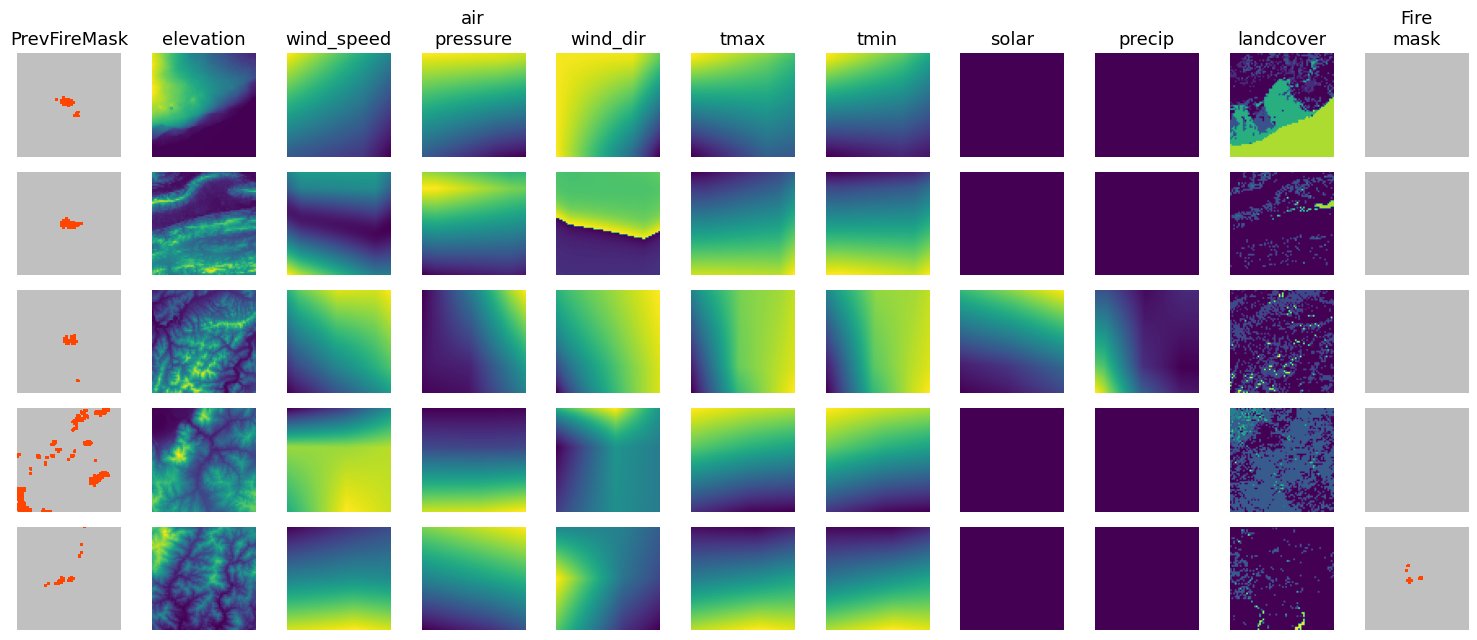

In [56]:
from matplotlib import colors

inputs, labels = next(iter(train_dataset))
print(f"inputs.shape: {inputs.shape}")
print(f"labels.shape: {labels.shape}")

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']
print(f"len(TITLES): {len(TITLES)}")


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

In [57]:
def build_generator(latent_dimension, conditional_image_shape):
    
    # Noise Input Layers
    noise_input_placeholder = Input(shape = (latent_dimension, ))
    x = Dense(1024)(noise_input_placeholder)
    x = Activation('tanh')(x)
    x = Dense(128 * 16 * 16)(x)
    x = BatchNormalization()(x)
    noise_input = Reshape((16, 16, 128), input_shape = (128 * 16 * 16, ))(x)
    
    # # Condition Input Layers
    # condition_input_placeholder = Input(shape = (latent_dimension, ))
    # x = Dense(1024)(condition_input_placeholder)
    # x = Activation('tanh')(x)
    # x = Dense(128 * 7 * 7)(x)
    # x = BatchNormalization()(x)
    # condition_input = Reshape((7, 7, 128), input_shape = (128 * 7 * 7, ))(x)

    # Condition Image Layers
    condition_input_placeholder = Input(conditional_image_shape)
    x = Conv2D(64, (5, 5), padding = 'same')(condition_input_placeholder)
    x = Activation('tanh')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Conv2D(128, (5, 5), padding = 'same')(x)
    x = Activation('tanh')(x)
    condition_input = MaxPooling2D(pool_size = (2, 2))(x)
    
    # Combined Input
    combined_input = Concatenate()([noise_input, condition_input])
    
    # Generator Block 1
    x = UpSampling2D(size = (2, 2))(combined_input)
    x = Conv2D(64, (5, 5), padding = 'same')(x)
    x = Activation('tanh')(x)
    
    # Generator Block 2
    x = UpSampling2D(size = (2, 2))(x)
    x = Conv2D(1, (5, 5), padding = 'same')(x)
    output = Activation('tanh')(x)
    
    generator = Model([noise_input_placeholder, condition_input_placeholder], output, name = 'Generator')
    
    return generator

In [58]:
def build_discriminator(image_shape, conditional_image_shape, latent_dimension):
    
    # Image Input Layers
    image_input_placeholder = Input(image_shape)
    x = Conv2D(64, (5, 5), padding = 'same')(image_input_placeholder)
    x = Activation('tanh')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Conv2D(128, (5, 5))(image_input_placeholder)
    x = Activation('tanh')(x)
    image_input = MaxPooling2D(pool_size = (2, 2))(x)
    
    # Previous Condition Input Layers
    # condition_input_placeholder = Input(shape = (latent_dimension, ))
    # x = Dense(1024)(condition_input_placeholder)
    # x = Activation('tanh')(x)
    # x = Dense(128 * 12 * 12)(x)
    # x = BatchNormalization()(x)
    # condition_input = Reshape((12, 12, 128), input_shape = (128 * 12 * 12, ))(x)
    
    # Condition Image Layers
    condition_input_placeholder = Input(conditional_image_shape)
    x = Conv2D(64, (5, 5), padding = 'same')(condition_input_placeholder)
    x = Activation('tanh')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Conv2D(128, (5, 5))(condition_input_placeholder)
    x = Activation('tanh')(x)
    condition_input = MaxPooling2D(pool_size = (2, 2))(x)
    
    combined_input = Concatenate()([image_input, condition_input])
    
    x = Flatten()(combined_input)
    x = Dense(1024)(x)
    x = Activation('tanh')(x)
    output = Dense(1, activation = 'sigmoid')(x)
    
    discriminator = Model([image_input_placeholder, condition_input_placeholder], output, name = 'Discriminator')
    
    return discriminator

In [59]:
def build_gan(generator, discriminator, image_shape, conditional_image_shape, latent_dimension):
    noise_input_placeholder = Input(shape = (latent_dimension, ), name = 'NoiseInput')
    condition_input_placeholder = Input(shape = (conditional_image_shape), name = 'ConditionInput')
    generated_image = generator([noise_input_placeholder, condition_input_placeholder])
    discriminator.trainable = False
    validity = discriminator([generated_image, condition_input_placeholder])
    gan = Model([noise_input_placeholder, condition_input_placeholder], validity)
    return gan

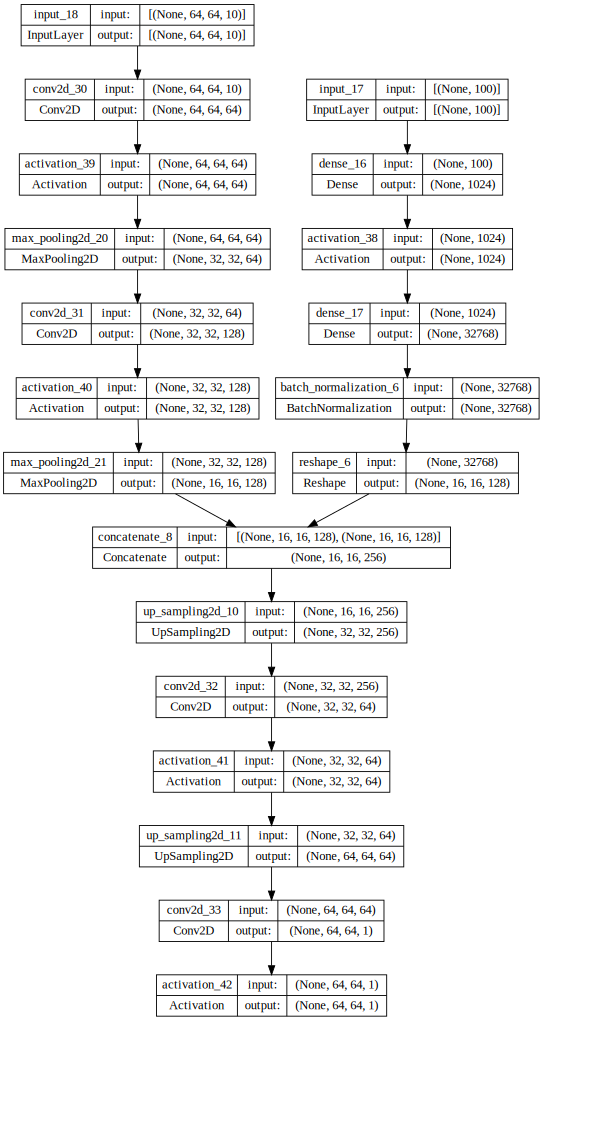

In [65]:
generator = build_generator(100, CONDITIONAL_IMAGE_SHAPE)
SVG(model_to_dot(generator, show_shapes = True, show_layer_names = True,dpi=65).create(prog = 'dot', format = 'svg'))

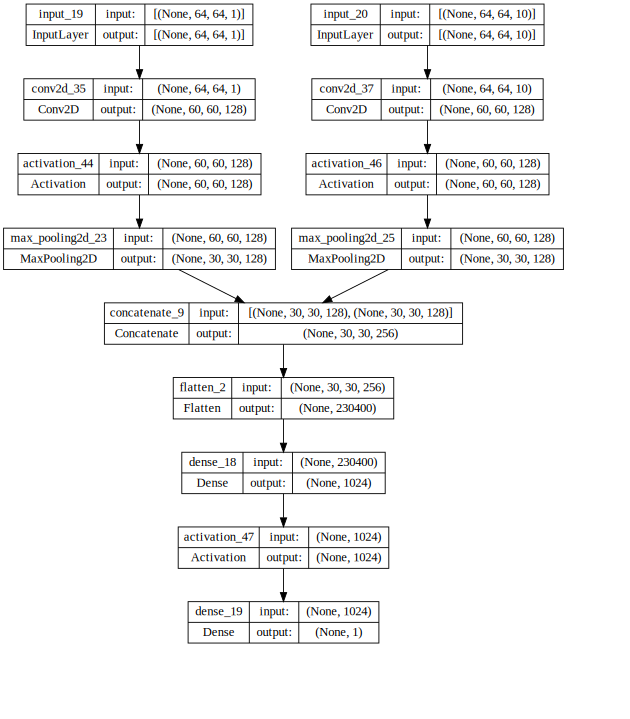

In [66]:
discriminator = build_discriminator((64, 64, 1), CONDITIONAL_IMAGE_SHAPE, 100)
SVG(model_to_dot(discriminator, show_shapes = True, show_layer_names = True, dpi=65).create(prog = 'dot', format = 'svg'))

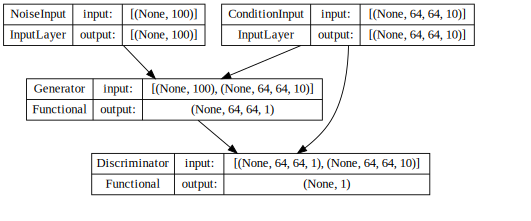

In [67]:
gan = build_gan(generator, discriminator, (64, 64, 1), CONDITIONAL_IMAGE_SHAPE, 100)
SVG(model_to_dot(gan, show_shapes = True, show_layer_names = True, dpi=65).create(prog = 'dot', format = 'svg'))

In [63]:
optimizer = Adam(0.0002, 0.5)

In [64]:
generator.compile(loss = 'binary_crossentropy', optimizer = optimizer)
gan.compile(loss = 'binary_crossentropy', optimizer = optimizer)
discriminator.trainable = True
discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer)

In [38]:
from tqdm.notebook import tqdm

for epoch in range(EPOCHS):
    
    progress_bar = tqdm(desc = "Epoch: {0}".format(epoch), total = 21550)
    
    generator_loss_history, discriminator_loss_history = [], []
    
    for batch_labels, batch_images in train_dataset:
        
        noise = np.random.uniform(0, 1, size = (BATCH_SIZE, LATENT_DIMENSION))
        
        # Get a Batch from the dataset
        # batch_images = x_train[iteration * BATCH_SIZE : (iteration + 1) * BATCH_SIZE]
        # batch_labels = y_train[iteration * BATCH_SIZE : (iteration + 1) * BATCH_SIZE]
        
        # Fake Images
        generated_images = generator.predict([noise, batch_labels])
        
        # Batch Dataset
        x = np.concatenate((batch_images, generated_images))
        y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
        discriminator_conditions = np.concatenate((batch_labels, batch_labels))
        
        # Training the Discriminator
        discriminator_loss = discriminator.train_on_batch([x, discriminator_conditions], y)
        discriminator_loss_history.append(discriminator_loss)
        
        noise = np.random.uniform(0, 1, size = (BATCH_SIZE, LATENT_DIMENSION))
        
        # Training the Generator
        discriminator.trainable = False
        generator_loss = gan.train_on_batch([noise, batch_labels], [1] * BATCH_SIZE)
        generator_loss_history.append(generator_loss)
        discriminator.trainable = True
        
        progress_bar.update(BATCH_SIZE)

KeyboardInterrupt: 

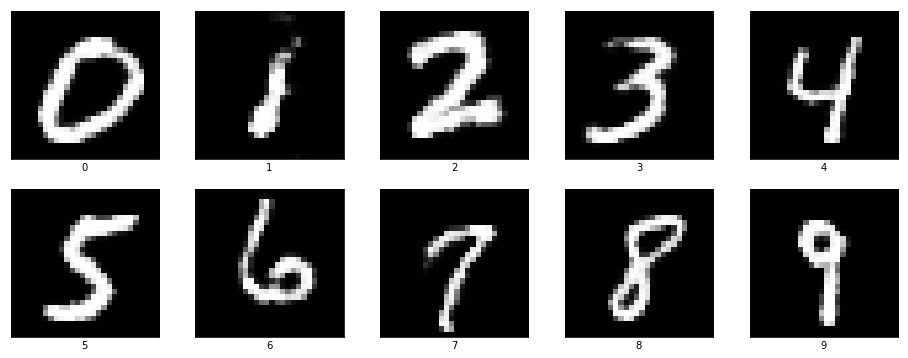

In [15]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (16, 6))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    noise = np.random.uniform(0, 1, size = (1, LATENT_DIMENSION))
    condition = to_categorical(np.array([i]), LATENT_DIMENSION)
    generated_image = generator.predict([noise, condition]).reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
    ax.imshow(generated_image, cmap = 'gray')
    ax.set_xlabel(str(i))
plt.show()

In [16]:
generator.save('./generator.h5')